## Istalling Library

In [1]:
!pip install nltk

In [ ]:
!pip install tensorflow-gpu==2.0.0

In [ ]:
pip install Sastrawi

In [ ]:
pip install googletrans

In [ ]:
!pip install tensorflow-gpu==2.0.0

## Import Library

In [6]:
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import tensorflow as tf
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from tensorflow.keras.models import model_from_json, load_model
from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import re


import matplotlib.pyplot as plt
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from googletrans import Translator

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Data

In [8]:
data_train = pd.read_csv("train_data_restaurant.tsv", sep='\t', names=['Kalimat', 'Sentimen'])
data_test = pd.read_csv("test_data_restaurant.tsv", sep='\t', names=['Kalimat', 'Sentimen'])

menyimpan kata - kata stopwords dari file id.stopwords.02.01.2016.txt ke dalam variable stopwords

In [10]:
stopwords = pd.read_csv('id.stopwords.02.01.2016.txt', names=['word'])

Definisikan seluruh label data ke dalam sebuah array

In [24]:
labels = data_train['Sentimen'].unique()
labels

array(['negative', 'positive'], dtype=object)

Kemudian cek jumlah artikel yang terdapat pada setiap label untuk melihat data yang dimiliki bersifat imbalance atau tidak.
Jika terlihat data yang memiliki jumlah 0, maka penamaan label kemungkinan ada yang salah

In [29]:
for label in labels:
    print(label)
    print(data_train[data_train['Sentimen']==label].shape[0])

negative
580
positive
1200


dapat dilihat datanya imbalance antara negatif dan positif. Kedua data tersebut memiliki selisih data sebesar 620 data.

In [116]:
list_kalimat = []
factory = StemmerFactory()
stemmer = factory.create_stemmer()
translator = Translator()
# factorysw = StopWordRemoverFactory()
# sw = factorysw.get_stop_words()

def remove_sw(list_kalimat, data):
  stopwords_list = stopwords['word'].tolist()
  for i, d in data.iterrows():
    text = d['Kalimat']
    # stop = sw.remove(text)
    translated = translator.translate(d['Kalimat'], src='en', dest='id')
    output   = stemmer.stem(translated.text)
    tokens = nltk.word_tokenize(output)
    j = 0
    length = len(tokens)
    while j < length:
    # for j in range(len(tokens)):
      if tokens[j] in stopwords_list:
        # print('pop')
        tokens.pop(j)
        length-=1
      j+=1
    split = ' '
    new_text = split.join(tokens)
    # print(new_text)
    list_kalimat.append(new_text)
  return list_kalimat
    # print(tokens)
  # print(list_kalimat)

## Preprocessing

### Menghilangkan atribut dan lowercase

atribut yang dihapus menggunakan regex yang hanya mengambil data alfabet dan melakukan lowercase dengan fungsi yang ada di dataframe

In [117]:
data_train['Kalimat'] = data_train['Kalimat'].str.lower()
data_test['Kalimat'] = data_test['Kalimat'].str.lower()
data_train['Kalimat'] = data_train['Kalimat'].apply((lambda x: re.sub('[^a-zA-z\s]','',x)))
data_test['Kalimat'] = data_test['Kalimat'].apply((lambda x: re.sub('[^a-zA-z\s]','',x)))

### Stemming menggunakan sastrawi dan menghapus stopwords

In [118]:
list_kalimat = []
df_train_clean = remove_sw(list_kalimat, data_train)
df_train = pd.DataFrame(df_train_clean, columns=['Kalimat'])
df_train['Sentimen'] = data_train['Sentimen']

In [119]:
list_kalimat = []
df_test_clean = remove_sw(list_kalimat, data_test)
df_test = pd.DataFrame(df_test_clean, columns=['Kalimat'])
df_test['Sentimen'] = data_test['Sentimen']

## Melakukan tokenizer dengan membatasi fitur nya dengan nilai 1000

### Melakukan tokenizer pada data training

In [120]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_train['Kalimat'].values)
X = tokenizer.texts_to_sequences(data_train['Kalimat'].values)
X = pad_sequences(X, padding="post", maxlen=60)
Y = pd.get_dummies(data_train['Sentimen']).values # Categorical | One Hot Encoding

# Y = np.array([1 if d == 'positive' else 0 for d in df_train['Sentimen']]) # Binary Label

### Melakukan tokenizer pada data testing

In [121]:
X_test = tokenizer.texts_to_sequences(df_test['Kalimat'].values)
X_test = pad_sequences(X_test, padding="post", maxlen=60)
Y_test = pd.get_dummies(df_test['Sentimen']).values #  Categorical | One Hot Encoding

# Y_test = np.array([1 if d == 'positive' else 0 for d in df_test['Sentimen']]) # Binary Label

# Split Data

Untuk dapat menguji model yang telah dibangun, maka lakukan split (pembagian) data train menjadi dua data berbeda, yaitu data train dan data validasi. 

Gunakan data validasi sebesar 33% dari data yang dimiliki.

In [122]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(1192, 60) (1192, 2)
(588, 60) (588, 2)


# Model

Kasus memprediksi data yang diberikan cocok menggunakan squential karena mampu memprediksi setiap training data yang digunakan dengan backpropagation seperti neural network

![alt text](https://indoml.files.wordpress.com/2018/03/kind-many-to-one2.jpg)

Langkah selanjutnya ialah membangun model klasifikasi dengan menggunakan metode LSTM

In [132]:
embed_dim = 16
lstm_out = 16

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#inisialisasi model dengan squential
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))

# Feature Extraction
# nilai dropout yang digunakan adalah 0.2 agar tidak merusak struktur arsitekture dari LSTM nya
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))

# Classifier
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 1, 'tanh'
# model akan di compile menggunakan parameter loss 'binary_crossentropy' dan optimizer 'adam'. binary_crossentropy digunakan untuk kasus dengan 2 label
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy']) # | binary_crossentropy
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 60, 16)            80000     
_________________________________________________________________
lstm_11 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_11 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 18        
Total params: 82,266
Trainable params: 82,266
Non-trainable params: 0
_________________________________________________________________
None


Arsitektur dari proses model yang akan saya buat dijelaskan pada model dibawah ini

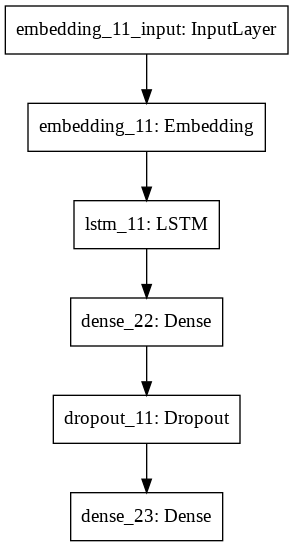

In [133]:
# Menampilkan layer yang telah dibuat
from tensorflow.keras.utils import plot_model
plot_model(model)

1. input layer dalam bentuk matriks embedding
2. melakukan proses embedding
3. membuat model LSTM
4. Membuat neuron 
5. melakukan dropout atau menghapus neuron/ dense yang tidak diperlukan secara random sebelumnya
6. menghubungkan ke dense atau neuron yang baru

mari kita tambahkan sebuah callback dengan nilai patience = 2 pada fungsi training

In [134]:
batch_size = 64
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    callbacks = [callback],
                    epochs = 40, batch_size=batch_size, verbose = 1)

Train on 1192 samples, validate on 588 samples
Epoch 1/40
1192/1192 [==============================] - 3s 3ms/sample - loss: 0.6709 - accuracy: 0.6485 - val_loss: 0.6448 - val_accuracy: 0.6769
Epoch 2/40
1192/1192 [==============================] - 1s 575us/sample - loss: 0.6521 - accuracy: 0.6728 - val_loss: 0.6340 - val_accuracy: 0.6769
Epoch 3/40
1192/1192 [==============================] - 1s 610us/sample - loss: 0.6442 - accuracy: 0.6728 - val_loss: 0.6364 - val_accuracy: 0.6769
Epoch 4/40
1192/1192 [==============================] - 1s 583us/sample - loss: 0.6422 - accuracy: 0.6728 - val_loss: 0.6316 - val_accuracy: 0.6769
Epoch 5/40
1192/1192 [==============================] - 1s 588us/sample - loss: 0.6415 - accuracy: 0.6728 - val_loss: 0.6300 - val_accuracy: 0.6769
Epoch 6/40
1192/1192 [==============================] - 1s 589us/sample - loss: 0.6369 - accuracy: 0.6728 - val_loss: 0.6267 - val_accuracy: 0.6769
Epoch 7/40
1192/1192 [==============================] - 1s 615us/sa

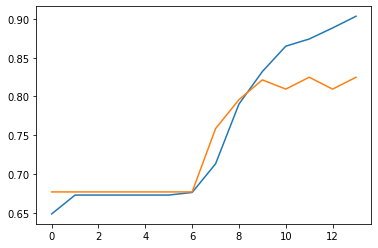

In [135]:
# Menampilkan grafik accuracy dan validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Tampilkan grafik yang telah diplot
plt.show()

Dilihat dari anugrasi val_accuracy kan tidak stabil dibandingkan accuracy tidak pernah turun. Dengan menggunakan hasil data training yang sudah split untuk mendapatkan model. Dapat dinyatakan bahwa originalitas data yg beragam heroengaruh terhadap akurasi Keberagaman data.

In [136]:
from sklearn.metrics import f1_score
Y_pred = model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
print(f1_score(Y_true, Y_pred, average='macro'))
print(f1_score(Y_true, Y_pred, average='micro'))


0.7850320336486415
0.8248299319727891


In [137]:
model.evaluate(X_val, Y_val, verbose = 2, batch_size = batch_size)

588/1 - 0s - loss: 0.6005 - accuracy: 0.8248


[0.4625412805550763, 0.82482994]

rata-rata loss yang didapatkan adalah sekitar 60% dengan hasil akurasi yakni 84%. Ini menunjukkan bahwa data overfit

In [138]:
model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)

185/1 - 0s - loss: 0.4020 - accuracy: 0.7514


[0.7280110468332832, 0.75135136]

rata-rata loss berkurang ketika model sudah diuji dengan data testing. Perbandingan nilai loss antar kedua data tersebut sebesar 0.1985 namun dengan begitu sudah mengurangi nilai overfit yang sudah diuji dimodel training sebelumnya. Akurasi berkurang menyeimbangi nilai val_accuracy.

Simpan model ke dalam file dengan format .h5

In [130]:
model.save("model.h5")

mencoba melakukan predicting kalimat ke 69 data testing kepada model yang sudah dibuat.

In [139]:
# predicting 
kalimat = [df_test['Kalimat'].loc[69]]
test = tokenizer.texts_to_sequences(kalimat)
test = pad_sequences(test, maxlen=X.shape[1])
vector = np.array([test.flatten()])
y = model.predict_classes(vector)
labels[y[0]]
# y[0]

'positive'